<a href="https://colab.research.google.com/github/vlamen/tue-deeplearning/blob/main/assignments/assignment_4/assignment_4_skeleton.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Group Number:

# Student 1:

# Student 2:

# Student 3:

# Imports

In [1]:
import numpy as np
import pickle
import requests

# other imports go here

# Data loading and inspection

In [2]:
# load and inspect data
data_location = 'https://surfdrive.surf.nl/files/index.php/s/K3ArFDQJb5USQ6K/download'
data_request = requests.get(data_location)
full_data = pickle.loads(data_request.content)

# Data augmentation and pipeline

unlabeled: (26000, 1, 32, 32)
labeled data: (2000, 1, 32, 32)
labeled labels: (2000, 5)
examples from labeled, repr1, repr2, unlabeled


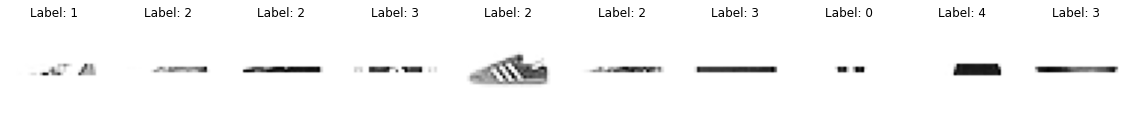

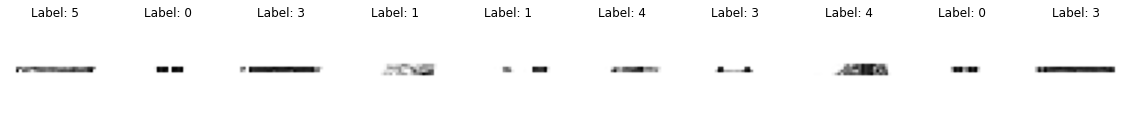

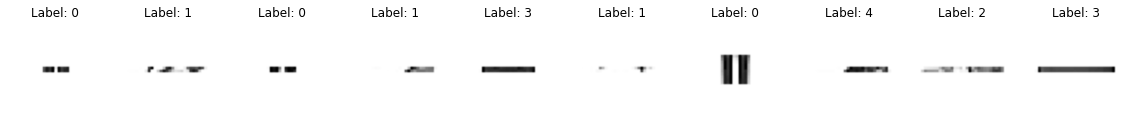

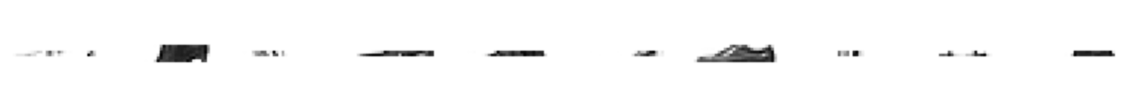

In [3]:
from torchvision.transforms.transforms import RandomRotation
# code for data augmentation pipeline 
print(f'unlabeled: {full_data["unlabeled_data"].shape}')
print(f'labeled data: {full_data["labeled_data"]["data"].shape}')
print(f'labeled labels: {full_data["labeled_data"]["labels"].shape}')

import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, utils

# augmentations
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.RandomRotation(degrees=(0,90)), 
        transforms.ColorJitter(),
        
])

# augmentations = []

batch_size = 10

class UnlabeledDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = torch.tensor(data)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if self.transform:
            return self.transform(self.data[idx].numpy()).permute((1, 2, 0))
        return self.data[idx]


class LabeledDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = torch.tensor(data['data'])
        self.labels = torch.tensor(data['labels'])
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if self.transform:
            return self.transform(self.data[idx].numpy()).permute((1, 2, 0)), self.labels[idx]
        return self.data[idx], self.labels[idx]


def show_images(x, y=None, ncols=batch_size):
    """ plots first ncols images in a batch """
    x = x.view(ncols, 32, 32)

    fig, ax = plt.subplots(1, ncols, figsize=(20, 2))
    for idx in range(ncols):
        ax[idx].imshow(x[idx].cpu().numpy(), cmap="Greys")
        ax[idx].axis('off')
        if y is not None:
            ax[idx].set_title(f'Label: {torch.nonzero(y[idx]).item()}')
    plt.show()

labeled_ds = LabeledDataset(full_data['labeled_data'], transform=transform)
repr_ds1 = LabeledDataset(full_data['representative_set_1'], transform=transform)
repr_ds2 = LabeledDataset(full_data['representative_set_2'], transform=transform)
unlabeled_ds = UnlabeledDataset(full_data['unlabeled_data'], transform=transform)

print('examples from labeled, repr1, repr2, unlabeled')
for dl in [DataLoader(ds, batch_size=batch_size, shuffle=True)
           for ds in [labeled_ds, repr_ds1, repr_ds2]]:
    for (x, y) in dl:
        # TODO: figure out why are the images flipped???
        show_images(x, y)
        break
for (x) in DataLoader(unlabeled_ds, batch_size=batch_size, shuffle=True):
    show_images(x)
    break

# Model definitions

In [4]:
# code for model definitions goes here
# model goals:
# 1. detect out of distribution data
# 2. give low (10) dimensional description of dataset in terms of the 5 modes
# 3. classify remaining data points into the 5 classes

# TODO ideas:
# generative model (task 1),
# embedding (task 2)
# self-supervised learning (task 3),

# similar to VAE practical 5.2
# e.g. train classifier on the vae's latent space by adding cross-entropy loss to the training
# (and thus third model encoder, decoder, classifier)

import torch.nn as nn

class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()
        self.input_dim = input_dim
        self.fc_input = nn.Linear(input_dim, hidden_dim)
        self.fc_hidden = nn.Linear(hidden_dim, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_sigma = nn.Linear (hidden_dim, latent_dim)
        
    def forward(self, x):
        h = torch.relu(self.fc_input(x))
        h = torch.relu(self.fc_hidden(h))
        mu = self.fc_mu(h)
        log_sigma = self.fc_sigma(h)
        z = self.reparameterization(mu, log_sigma)

        return z, mu, log_sigma
    
    def reparameterization(self, mu, log_sigma):
        sigma = torch.exp(log_sigma)
        epsilon = torch.rand_like(sigma)
        z = mu + sigma * epsilon
        
        return z

class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.fc_hidden1 = nn.Linear(latent_dim, hidden_dim)
        self.fc_hidden2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_output = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        h = torch.relu(self.fc_hidden1(x))
        h = torch.relu(self.fc_hidden2(h))
        x_reconstr = torch.sigmoid(self.fc_output(h))
        return x_reconstr


class Classifier(nn.Module):
    def __init__(self, latent_dim, hidden_dim, n_classes):
        super(Classifier, self).__init__()
        self.fc_hidden1 = nn.Linear(latent_dim, hidden_dim)
        self.fc_hidden2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_output = nn.Sequential(nn.Linear(hidden_dim, n_classes),nn.Softmax(dim=1))
        
    def forward(self, x):
        h = torch.relu(self.fc_hidden1(x))
        h = torch.relu(self.fc_hidden2(h))
        out = self.fc_output(h)
        return out


class VAE(nn.Module):
    def __init__(self, encoder, decoder, classifier):
        super(VAE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.classifier = classifier
            
    def forward(self, x):
        x = x.view(batch_size, encoder.input_dim)
        z, mu, log_sigma = self.encoder(x)
        x_reconstr = self.decoder(z)
        y = self.classifier(z)

        return x_reconstr, mu, log_sigma, y

# Training and validation loop

In [5]:
# write your training and validation loop here

input_dim = 32*32
hidden_dim = 50
latent_dim = 10
n_classes = 5

encoder = Encoder(input_dim=input_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
decoder = Decoder(latent_dim=latent_dim, hidden_dim=hidden_dim, output_dim=input_dim)
classifier = Classifier(latent_dim=latent_dim, hidden_dim=hidden_dim, n_classes=n_classes)

vae = VAE(encoder=encoder, decoder=decoder, classifier=classifier)

In [6]:
# Then, train on the labeled data
# perform training

# train on the labeled data
epochs = 10

import torch.optim as optim
from tqdm import tqdm
import torch.nn as nn

lr = 1e-3

def loss_function(x, x_reconstr, mu, log_sigma, y=None, y_pred=None):
    classify_loss = 0
    reconstr_loss = nn.functional.mse_loss(x_reconstr.reshape(-1,1,32,32), x, reduction='sum')
    kl_loss = 0.5 * torch.sum(mu.pow(2) + (2*log_sigma).exp() - 2*log_sigma - 1)

    if y is not None and y_pred is not None:
        # TODO: add classification loss here (cross entropy)
        # TODO: should this also add some kind of divergence to push different classes away?????
        # criterion = nn.functional.cross_entropy()
        classify_loss = nn.functional.cross_entropy(y_pred,y)

    total_loss = reconstr_loss + kl_loss + classify_loss

    return total_loss, reconstr_loss, kl_loss, classify_loss
# def loss_function(x, x_reconstr, mu, log_sigma, y=None, y_pred=None):
#     reconstr_loss = nn.functional.mse_loss(x_reconstr.reshape(-1,1,32,32), x, reduction='sum')
#     kl_loss = 0.5 * torch.sum(mu.pow(2) + (2*log_sigma).exp() - 2*log_sigma - 1)
#     total_loss = reconstr_loss + kl_loss
#     if y is not None and y_pred is not None:
#         # TODO: add classification loss here (cross entropy)
#         # TODO: should this also add some kind of divergence to push different classes away?????
#         pass
#     return total_loss, reconstr_loss, kl_loss

def fit_unlabeled(model, dl):
    print("Start training VAE...")
    loss_graph = {'overall': [], 'reconstr': [], 'kl': []}
    

    for epoch in tqdm(range(epochs)):
        model.train()
        optimizer = optim.Adam(model.parameters(), lr=lr)
        overall_loss = 0
        overall_reconstr_loss = 0
        overall_kl_loss = 0
        n_datapoints = 0
        for x in dl:
            optimizer.zero_grad()

            # y is unused for unlabeled data
            x_reconstr, mu, log_sigma, _ = model(x)
            loss, reconstr_loss, kl_loss, _ = loss_function(x, x_reconstr, mu, log_sigma)
 
            overall_loss += loss.item()
            overall_reconstr_loss += reconstr_loss.item()
            overall_kl_loss += kl_loss.item()
            
            loss.backward()
            optimizer.step()
            
            n_datapoints += batch_size
        loss_graph['overall'].append(overall_loss / n_datapoints)
        loss_graph['reconstr'].append(overall_reconstr_loss / n_datapoints)
        loss_graph['kl'].append(overall_kl_loss / n_datapoints)

    print("Training complete!")
    return loss_graph

graph = fit_unlabeled(vae, DataLoader(unlabeled_ds, batch_size=batch_size, shuffle=True))

Start training VAE...


100%|██████████| 10/10 [03:00<00:00, 18.06s/it]

Training complete!


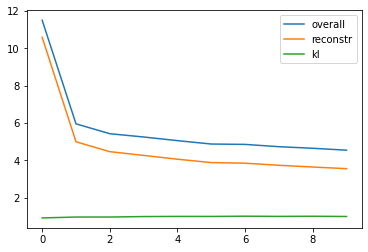

In [7]:
for label in ['overall', 'reconstr', 'kl']:
    plt.plot(np.arange(0, epochs), graph[label], label=label)
plt.legend()
plt.show()


torch.Size([10, 1, 32, 32])
torch.Size([10, 1024])


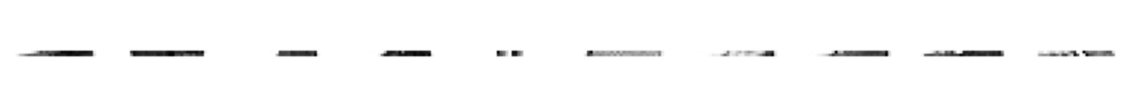

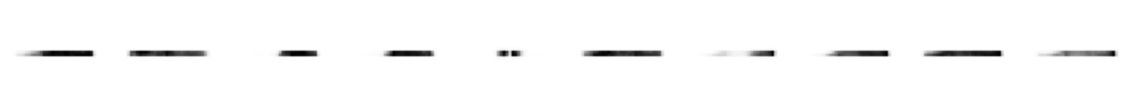

In [8]:
# Show some examples of vae-encoded images
for x in DataLoader(unlabeled_ds, batch_size=batch_size, shuffle=True):
     with torch.no_grad():
          x_reconstr, _, _, _ = vae(x)
          print(x.shape)
          print(x_reconstr.shape)
          show_images(x)
          show_images(x_reconstr)
          break

In [9]:
# perform training

# First, train on the unlabeled data
epochs = 10

import torch.optim as optim
from tqdm import tqdm
import torch.nn.functional

lr = 1e-4

def loss_function(x, x_reconstr, mu, log_sigma, y=None, y_pred=None):
    classify_loss = 0
    reconstr_loss = nn.functional.mse_loss(x_reconstr.reshape(-1,1,32,32), x, reduction='sum')
    kl_loss = 0.5 * torch.sum(mu.pow(2) + (2*log_sigma).exp() - 2*log_sigma - 1)

    if y is not None and y_pred is not None:
        # TODO: should this also add some kind of divergence to push different classes away?????

        #classify_loss = nn.functional.cross_entropy(y_pred,y)
        classify_loss = torch.sum(-y * torch.log(y_pred) - (1 - y) * torch.log(1 - y_pred))

    total_loss = reconstr_loss + kl_loss + classify_loss

    return total_loss, reconstr_loss, kl_loss, classify_loss

def fit_labeled(model, dl):
    print("Start training VAE...")
    loss_graph = {'overall': [], 'reconstr': [], 'kl': [], 'classify': []}
    for epoch in tqdm(range(epochs)):
        model.train()
        optimizer = optim.SGD(model.parameters(), lr=lr)
        overall_loss = 0
        overall_reconstr_loss = 0
        overall_kl_loss = 0
        overall_classify_loss = 0
        n_datapoints = 0
        for (x,y) in dl:
            optimizer.zero_grad()

            x_reconstr, mu, log_sigma, y_pred = model(x)
            
            # print(f"y:\n{y},\n pred:\n{y_pred}")
            loss, reconstr_loss, kl_loss, classify_loss = loss_function(x, x_reconstr, mu, log_sigma, y, y_pred)
 
            overall_loss += loss.item()
            overall_reconstr_loss += reconstr_loss.item()
            overall_kl_loss += kl_loss.item()
            overall_classify_loss += classify_loss.item()
            
            loss.backward()
            optimizer.step()
            
            n_datapoints += batch_size
        loss_graph['overall'].append(overall_loss / n_datapoints)
        loss_graph['reconstr'].append(overall_reconstr_loss / n_datapoints)
        loss_graph['kl'].append(overall_kl_loss / n_datapoints)
        loss_graph['classify'].append(overall_classify_loss / n_datapoints)
        print(f"\n overall:{overall_loss / n_datapoints}\n reconstr:{overall_reconstr_loss / n_datapoints}\n kl:{overall_kl_loss / n_datapoints}\n classify:{overall_classify_loss / n_datapoints}")

    print("Training complete!")
    return loss_graph

graph = fit_labeled(vae, DataLoader(labeled_ds, batch_size=batch_size, shuffle=True))

Start training VAE...


 10%|█         | 1/10 [00:01<00:10,  1.18s/it]


 overall:6.944960357666016
 reconstr:3.468616618156433
 kl:0.9780383956432342
 classify:2.4983053398132324


 20%|██        | 2/10 [00:02<00:09,  1.17s/it]


 overall:7.075303787231445
 reconstr:3.591195740222931
 kl:0.9970811846256256
 classify:2.4870268573760987


 30%|███       | 3/10 [00:03<00:08,  1.17s/it]


 overall:6.803967563629151
 reconstr:3.3483824586868285
 kl:0.9812131364345551
 classify:2.474371970176697


 40%|████      | 4/10 [00:04<00:07,  1.17s/it]


 overall:6.659810218811035
 reconstr:3.2366022477149965
 kl:0.9601960508823395
 classify:2.4630119075775148


 50%|█████     | 5/10 [00:05<00:05,  1.16s/it]


 overall:6.745960910797119
 reconstr:3.323998777627945
 kl:0.9689746153354645
 classify:2.4529875268936157


 60%|██████    | 6/10 [00:07<00:04,  1.17s/it]


 overall:6.839001113891602
 reconstr:3.4071380286216737
 kl:0.988249627828598
 classify:2.4436134691238403


 70%|███████   | 7/10 [00:08<00:03,  1.17s/it]


 overall:7.041037876129151
 reconstr:3.5787023701667784
 kl:1.029861616373062
 classify:2.432473909378052


 80%|████████  | 8/10 [00:09<00:02,  1.18s/it]


 overall:6.812877670288086
 reconstr:3.4014787015914916
 kl:0.9906015751361847
 classify:2.4207974071502685


 90%|█████████ | 9/10 [00:10<00:01,  1.18s/it]


 overall:6.7789100074768065
 reconstr:3.384681136608124
 kl:0.983620364189148
 classify:2.410608525276184


100%|██████████| 10/10 [00:11<00:00,  1.18s/it]


 overall:6.7237079830169675
 reconstr:3.354091320514679
 kl:0.97236283493042
 classify:2.3972538156509398
Training complete!


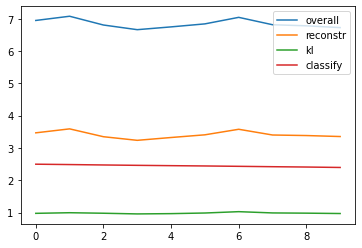

In [10]:
for label in ['overall', 'reconstr', 'kl', 'classify']:
    plt.plot(np.arange(0, epochs), graph[label], label=label)
plt.legend()
plt.show()

# Inspection, Validation, and Analysis

In [ ]:
# Inspect, validate, and analyse your trained model

In [11]:
## TODO: ROC haven't finished

def test(model, dl):
    '''
    Calculate FP, TP -> ROC.
    Return scores: (FP, TP, accuracy)
    '''
    model = model.eval()
    running_tp = 0.0
    running_fp = 0.0
    running_acc = 0.0
    with torch.no_grad():
        for (x, y) in dl:
            if torch.cuda.is_available():
                x = x.cuda()
                y = y.cuda()

            x_reconstr, mu, log_sigma, y_pred = model(x)
            y_one_hot = torch.zeros(batch_size,5).scatter_(1,label,1)
            print(y_one_hot)
            # y = y.cuda()
        #     running_tp += (((preds == 1) & (yb == 1)).sum() / (yb == 1).sum()).item()
        #     running_fp += (((preds == 1) & (yb == 0)).sum() / (yb == 0).sum()).item()
        #     running_acc += ((preds == yb).sum() / yb.shape[0] / yb.shape[1]).item()
            
        # n = len(test_loader)
        # return (running_fp / n, running_tp / n, running_acc / n)

def plot_roc(model, loader, thresholds, desc="Validation"):
    rocs = [test(model, loader, t) for t in thresholds]
    # Split tuples into x and y, x = FP and y = TP
    x = [roc[0] for roc in rocs]
    y = [roc[1] for roc in rocs]
    # z = accuracy, is not plotted
    z = [roc[2] for roc in rocs]
    plt.plot(x, y)
    plt.title(f"{desc} ROC")
    plt.xlabel("false positive rate")
    plt.ylabel("true positive rate")
    return x, y, z


In [23]:
#test(vae,DataLoader(labeled_ds, batch_size=batch_size, shuffle=True))
vae = vae.eval()
running_tp = 0.0
running_fp = 0.0
running_acc = 0.0
with torch.no_grad():
    for (x, y) in dl:
        x_reconstr, mu, log_sigma, y_pred = vae(x)
        # print(f"{y}\n")
        # index = torch.tensor([[0, 1, 2, 0]])
        y_one_hot = torch.zeros(batch_size,6).scatter_(1,x_reconstr.unsqueeze,1)
        print(y_one_hot)

RuntimeError: ignored